In [1]:
import neo
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import label

In [2]:
def peak_detection(ts,filt=False,thresh=False):
    if filt:
        baseline = medfilt(ts, kernel_size=801)
        ts-=baseline
    
    if thresh!=False:
        above_thresh=ts>thresh
    else:
        above_thresh=ts>(ts.mean()+3*ts.std())
    labs,nlabs = label(above_thresh)
    peak_idxs = []
    for l in range(1,nlabs+1):
        idxs = np.where(labs==l)[0]
        vals = ts[idxs]
        peak_idx = idxs[np.argmax(vals)]
        peak_idxs.append(peak_idx)
    peak_heights = ts[peak_idxs]
    return peak_idxs,peak_heights
def load_data(f):
    r = neo.AxonIO(filename=f)
    block = r.read_block()
    segment = block.segments[0]
    dat=[(np.asarray(x.times),np.asarray(x)) for x in segment.analogsignals]
    return dat

In [243]:
x=load_data('lab6/19o09013-fly2-cg-cont-cw-5s-2so.abf')

FileNotFoundError: [Errno 2] No such file or directory: 'lab6/19o09013-fly2-cg-cont-cw-5s-2so.abf'

In [226]:
x=load_data('lab6/19o09013-fly2-csf-cont-cw-5s-2so.abf')
times_data,mag_data=x[0]
times_mro,mag_mro=x[1]

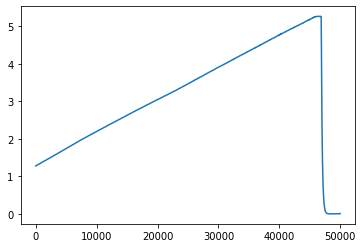

In [229]:
plt.plot(mag_mro[200000:250000])

(array([6., 5., 6., 5., 5., 5., 5., 2., 1., 1., 5., 7., 0., 4., 3., 2., 3.,
        2., 5., 1., 2., 0., 3., 0., 1., 1., 2., 2., 0., 3., 1., 3., 1., 2.,
        1., 1., 4., 0., 1., 1., 0., 2., 0., 4., 0., 2., 0., 0., 1., 1., 2.,
        0., 0., 1., 0., 1., 0., 0., 0., 2., 1., 0., 0., 1., 3., 0., 1., 0.,
        0., 0., 1., 1., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.]),
 array([ 93.68896 ,  94.274895,  94.86083 ,  95.44677 ,  96.03271 ,
         96.618645,  97.20458 ,  97.79052 ,  98.37646 ,  98.962395,
         99.54833 , 100.13427 , 100.72021 , 101.306145, 101.89208 ,
        102.47802 , 103.06396 , 103.649895, 104.23583 , 104.82177 ,
        105.40771 , 105.993645, 106.57958 , 107.16552 , 107.75146 ,
        108.337395, 108.92333 , 109.50927 , 110.09521 , 110.681145,
        111.26708 , 111.85302 , 112.43896 , 113.024895, 113.61083 ,
        114.19677 , 114.78271 , 115.368645, 115.95458 , 116.54052 ,
      

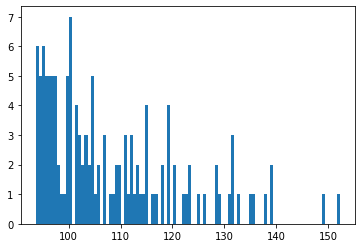

In [230]:
peak_idxs,peak_heights=peak_detection(mag_data[200000:250000])
plt.hist(peak_heights,bins=100)

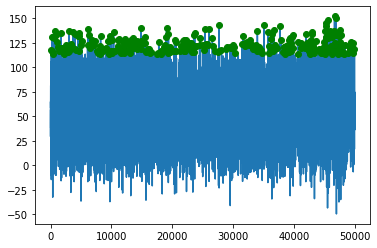

In [126]:
plt.plot(mag_data[150000:200000])
plt.plot(peak_idxs,peak_heights,'go')


In [4]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
def spike_sort(ts,window=.025):
    window_length=int(window/0.0001)
    peak_idxs,peak_heights=peak_detection(ts)
    X=peak_heights.reshape([-1,1])
    scores=[]
    options=list(range(2,10))
    for n_cluster in options:
        km = KMeans(n_clusters=n_cluster).fit(X)
        scores.append(silhouette_score(X,km.labels_))
    km = KMeans(n_clusters=options[np.argmax(scores)]).fit(X)
    km.fit(X)
    wave_forms=[[] for i in list(set(km.labels_))]
    for i,lbl in enumerate(list(set(km.labels_))):
        idxs=np.asarray(peak_idxs)[km.labels_==lbl]
        #print(idxs)
        for idx in idxs:
            a=idx-window_length
            b=idx+window_length
            if a>=0 and b<=ts.shape[0]-1:
                wave_forms[i].append(ts[a:b])
    wave_forms_final=[]
    for i in range(len(wave_forms)):
        if len(wave_forms[i])>0:
            wave_forms_final.append(np.hstack(wave_forms[i]))
    return (peak_heights.shape[0],wave_forms_final)
            
        


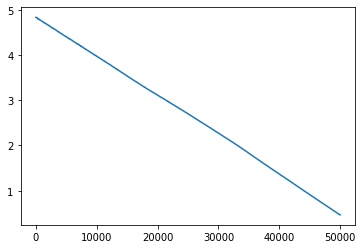

In [255]:
plt.plot(mag_mro[600000:650000])

In [232]:
wave_forms=spike_sort(mag_data[200000:250000])
len(wave_forms)

2

In [266]:
x=load_data('lab6/19o09013-fly2-csf-cont-cw-5s-2so.abf')

the default signal_group_mode will change from 'split-all' to 'group-by-same-units' in next release


AttributeError: 'int' object has no attribute 'shape'

In [335]:
x=load_data('lab6/19o09013-fly2-csf-cont-ccw-5s-2so.abf')
times_data,mag_data=x[0]
times_mro,mag_mro=x[1]
#change_points=np.where(np.diff(mag_mro==0)>1)[0]
idxs=np.where(mag_mro==0)[0]
change_points=idxs[np.where(np.diff(idxs)>10000)]

i=0
counts_ccw=[]
while i<len(change_points)-1:
    num_spikes,wave_forms=spike_sort(mag_data[change_points[i]:change_points[i+1]])
    counts_ccw.append(num_spikes)
    i+=1

x=load_data('lab6/19o09013-fly2-csf-cont-cw-5s-2so.abf')
times_data,mag_data=x[0]
times_mro,mag_mro=x[1]
#change_points=np.where(np.diff(mag_mro==0)>1)[0]
idxs=np.where(mag_mro==0)[0]
change_points=idxs[np.where(np.diff(idxs)>10000)]

i=0
counts_cw=[]
while i<len(change_points)-1:
    num_spikes,wave_forms=spike_sort(mag_data[change_points[i]:change_points[i+1]])
    counts_cw.append(num_spikes)
    i+=1

the default signal_group_mode will change from 'split-all' to 'group-by-same-units' in next release
the default signal_group_mode will change from 'split-all' to 'group-by-same-units' in next release


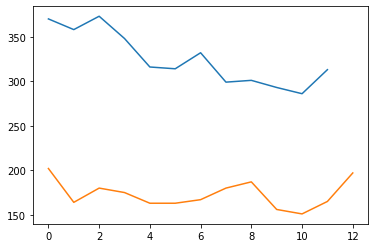

In [337]:
plt.plot(counts_ccw[:-1])
plt.plot(counts_cw[:-1])

In [344]:
x=load_data('lab6/19o09014-fly2-cg-cont-ccw-5s-2so.abf')
times_data,mag_data=x[0]
times_mro,mag_mro=x[1]
#change_points=np.where(np.diff(mag_mro==0)>1)[0]
idxs=np.where(mag_mro==0)[0]
change_points=idxs[np.where(np.diff(idxs)>10000)]

i=0
counts_ccw=[]
while i<len(change_points)-1:
    num_spikes,wave_forms=spike_sort(mag_data[change_points[i]:change_points[i+1]])
    counts_ccw.append(num_spikes)
    i+=1

x=load_data('lab6/19o09015-fly2-cg-cont-cw-5s-2so.abf')
times_data,mag_data=x[0]
times_mro,mag_mro=x[1]
#change_points=np.where(np.diff(mag_mro==0)>1)[0]
idxs=np.where(mag_mro==0)[0]
change_points=idxs[np.where(np.diff(idxs)>10000)]

i=0
counts_cw=[]
while i<len(change_points)-1:
    num_spikes,wave_forms=spike_sort(mag_data[change_points[i]:change_points[i+1]])
    counts_cw.append(num_spikes)
    i+=1

the default signal_group_mode will change from 'split-all' to 'group-by-same-units' in next release
the default signal_group_mode will change from 'split-all' to 'group-by-same-units' in next release


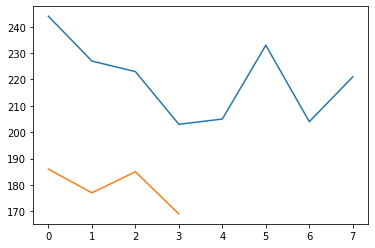

In [345]:
plt.plot(counts_ccw[:-1])
plt.plot(counts_cw[:-1])

the default signal_group_mode will change from 'split-all' to 'group-by-same-units' in next release


[  33966   74001  114047  154039  194107  234122  274153  314227  354228
  394226  434242  474308  514337  554400  594437  634449  674510  714519
  754568  794617  834627  874635  914655  954710  994748 1034808 1074851
 1114862 1154915 1194925 1234973 1275031 1315048 1355050 1395059 1435105
 1475151 1515210]


/tigress/sreejank/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


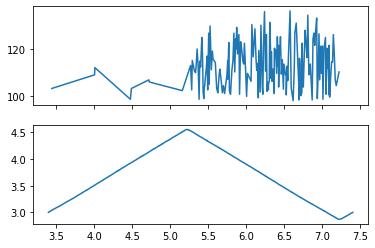

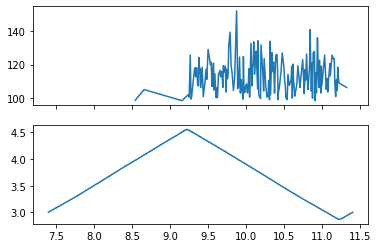

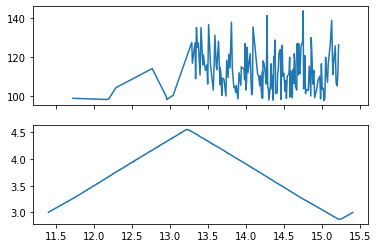

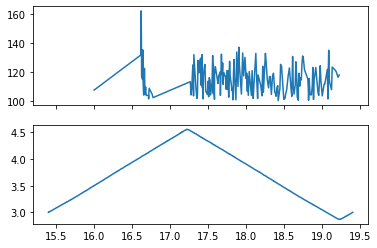

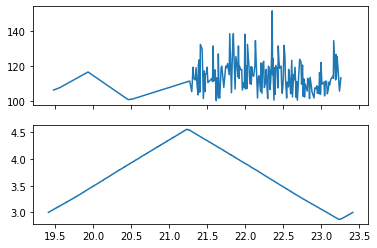

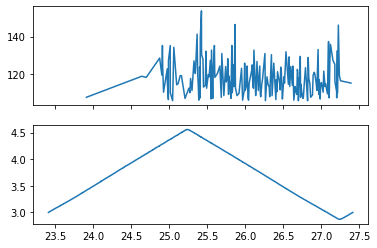

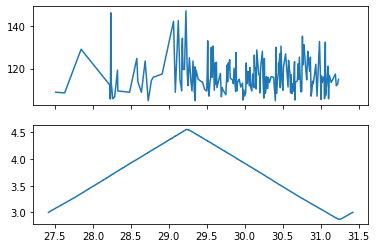

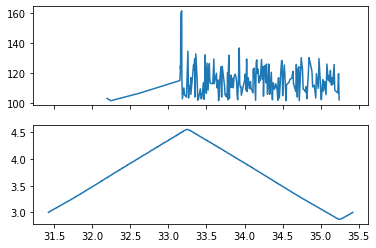

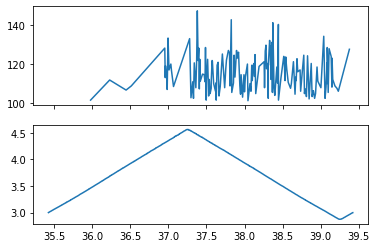

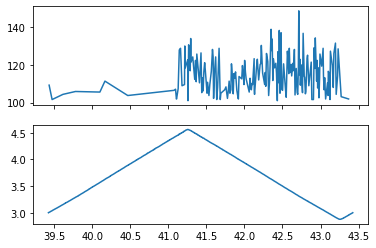

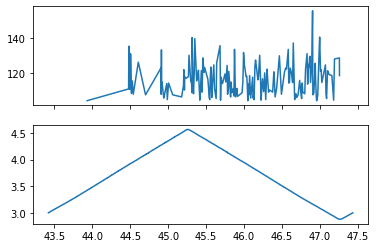

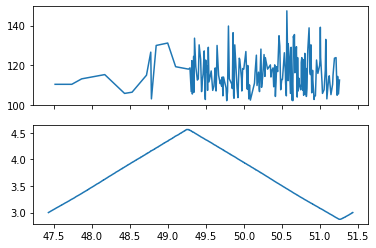

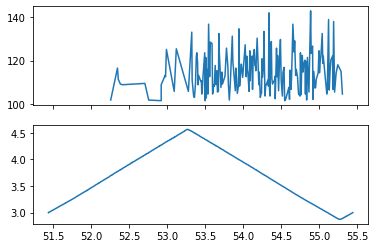

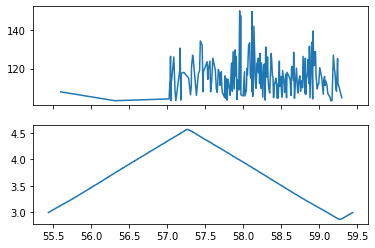

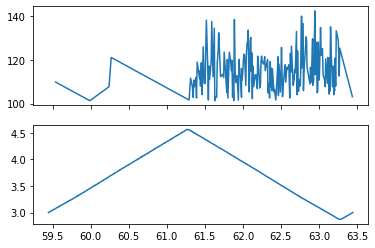

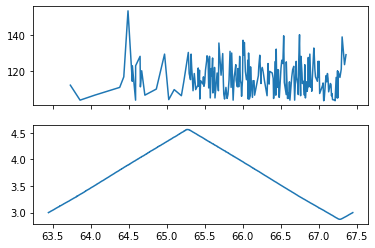

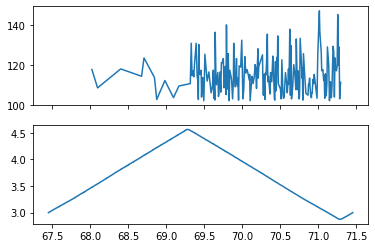

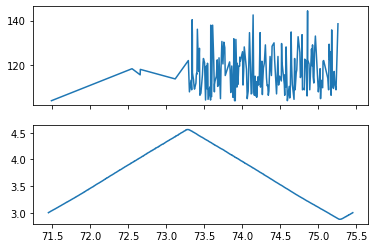

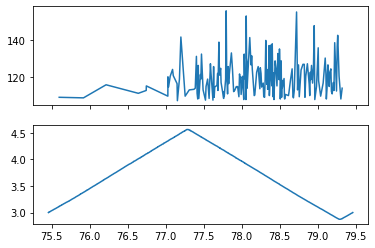

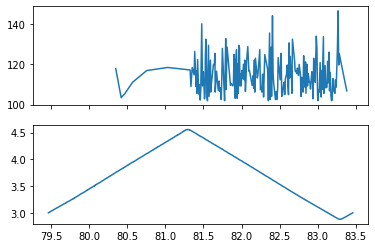

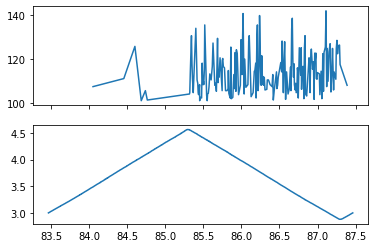

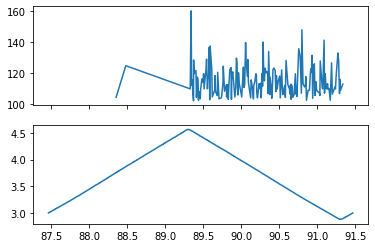

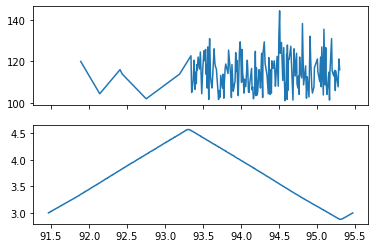

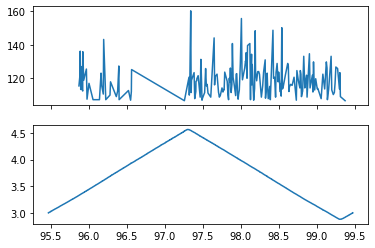

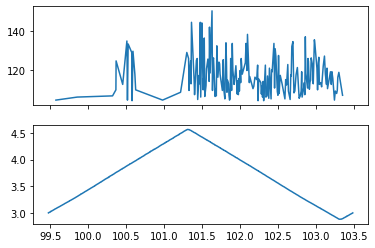

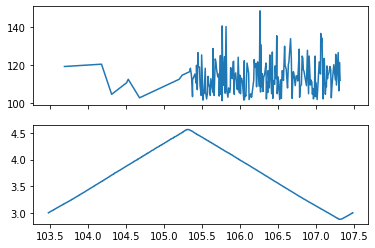

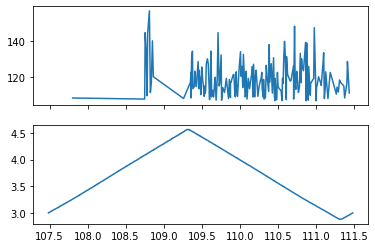

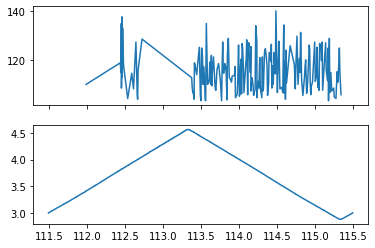

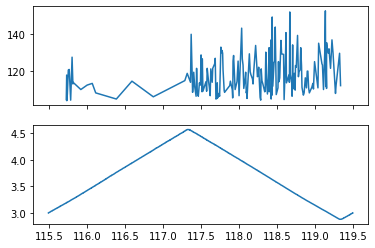

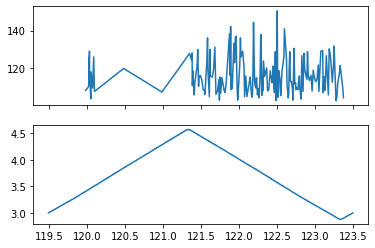

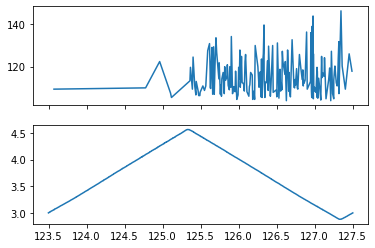

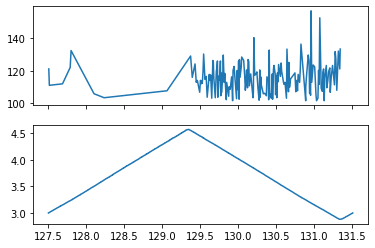

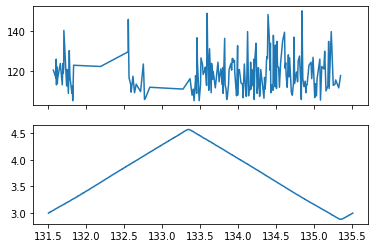

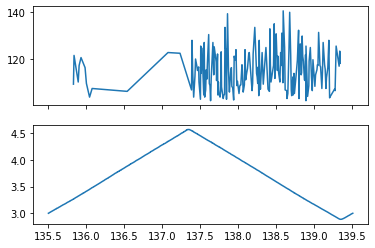

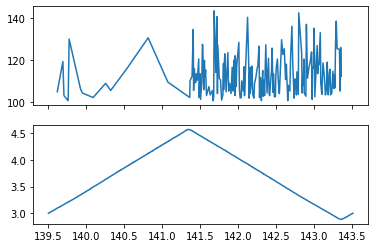

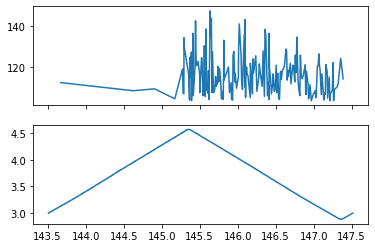

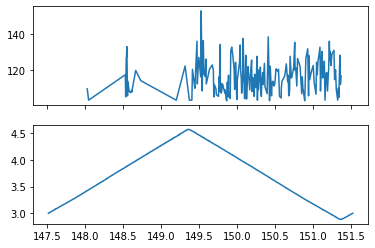

In [12]:
x=load_data('lab6/19o09012-fly2-csf-osc-ccw-5s-2so.abf')
times_data,mag_data=x[0]
times_mro,mag_mro=x[1]
idxs=np.where(mag_mro<3)[0]
change_points=idxs[np.where(np.diff(idxs)>10000)]
i=0
#fig,axarr=plt.subplots(2,sharex=True)
print(change_points)
while i<len(change_points)-1:
    a=change_points[i]
    b=change_points[i+1]
    i+=1
    peak_idxs,peak_heights=peak_detection(mag_data[a:b])
    ifr=(1/np.diff(peak_idxs))
    fig,axarr=plt.subplots(2,sharex=True)
    #axarr[0].plot(times_data[a:b][peak_idxs][1:],ifr)
    axarr[0].plot(times_data[a:b][peak_idxs],mag_data[a:b][peak_idxs])
    axarr[1].plot(times_mro[a:b],mag_mro[a:b])

the default signal_group_mode will change from 'split-all' to 'group-by-same-units' in next release


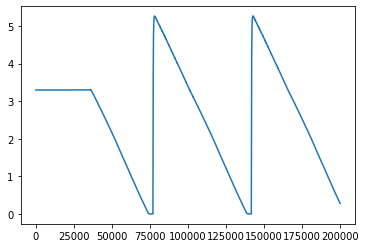

In [505]:
x=load_data('lab6/19o09014-fly2-cg-cont-ccw-5s-2so.abf')
times_data,mag_data=x[0]
times_mro,mag_mro=x[1]
plt.plot(mag_mro[:200000])

In [521]:
times_data[a:b]

array([46.449 , 46.4491, 46.4492, ..., 59.3674, 59.3675, 59.3676])

In [522]:
len([idx for idx in peak_idxs if idx>= start and idx<finish])

NameError: name 'start' is not defined

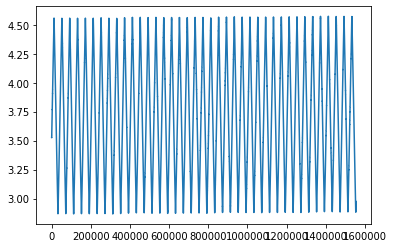

In [538]:
#print(peak_idxs)

plt.plot(mag_mro)
    

In [576]:
cmap = plt.cm.Spectral.jet

AttributeError: 'LinearSegmentedColormap' object has no attribute 'jet'

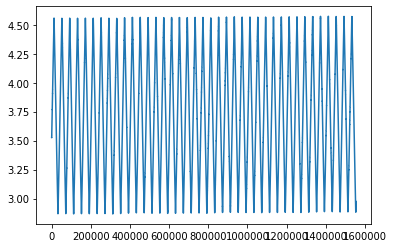

In [19]:
plt.plot(mag_mro)

the default signal_group_mode will change from 'split-all' to 'group-by-same-units' in next release


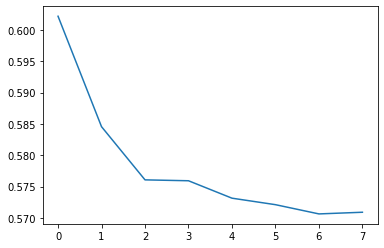

In [95]:
x=load_data('lab6/19o09012-fly2-csf-osc-ccw-5s-2so.abf')
times_data,mag_data=x[0]
times_mro,mag_mro=x[1]
idxs=np.where(mag_mro<3)[0]
change_points=idxs[np.where(np.diff(idxs)>5000)]
i=0
scores_all=[]
while i<len(change_points)-1:
    a=change_points[i]
    b=change_points[i+1]
    i+=1
    peak_idxs,peak_heights=peak_detection(mag_data[a:b])
    X=peak_heights.reshape([-1,1])
    scores=[]
    options=list(range(2,10))
    for n_cluster in options:
        km = KMeans(n_clusters=n_cluster).fit(X)
        scores.append(silhouette_score(X,km.labels_))
    scores_all.append(np.asarray(scores))
plt.plot(np.asarray(scores_all).mean(axis=0))

In [99]:
np.asarray(scores_all)[:,0]

array([0.59136516, 0.59332496, 0.56630164, 0.6007263 , 0.5993119 ,
       0.6240905 , 0.6140219 , 0.60010564, 0.64497775, 0.60057986,
       0.59306484, 0.6076403 , 0.59794766, 0.5935837 , 0.57582814,
       0.59876835, 0.58131844, 0.61623186, 0.598705  , 0.5960359 ,
       0.62256014, 0.6197526 , 0.5801938 , 0.58656234, 0.61982286,
       0.5820451 , 0.6248764 , 0.62528265, 0.6125343 , 0.63486034,
       0.63363194, 0.55423415, 0.60475755, 0.5999483 , 0.61121553,
       0.5895716 , 0.58525354], dtype=float32)

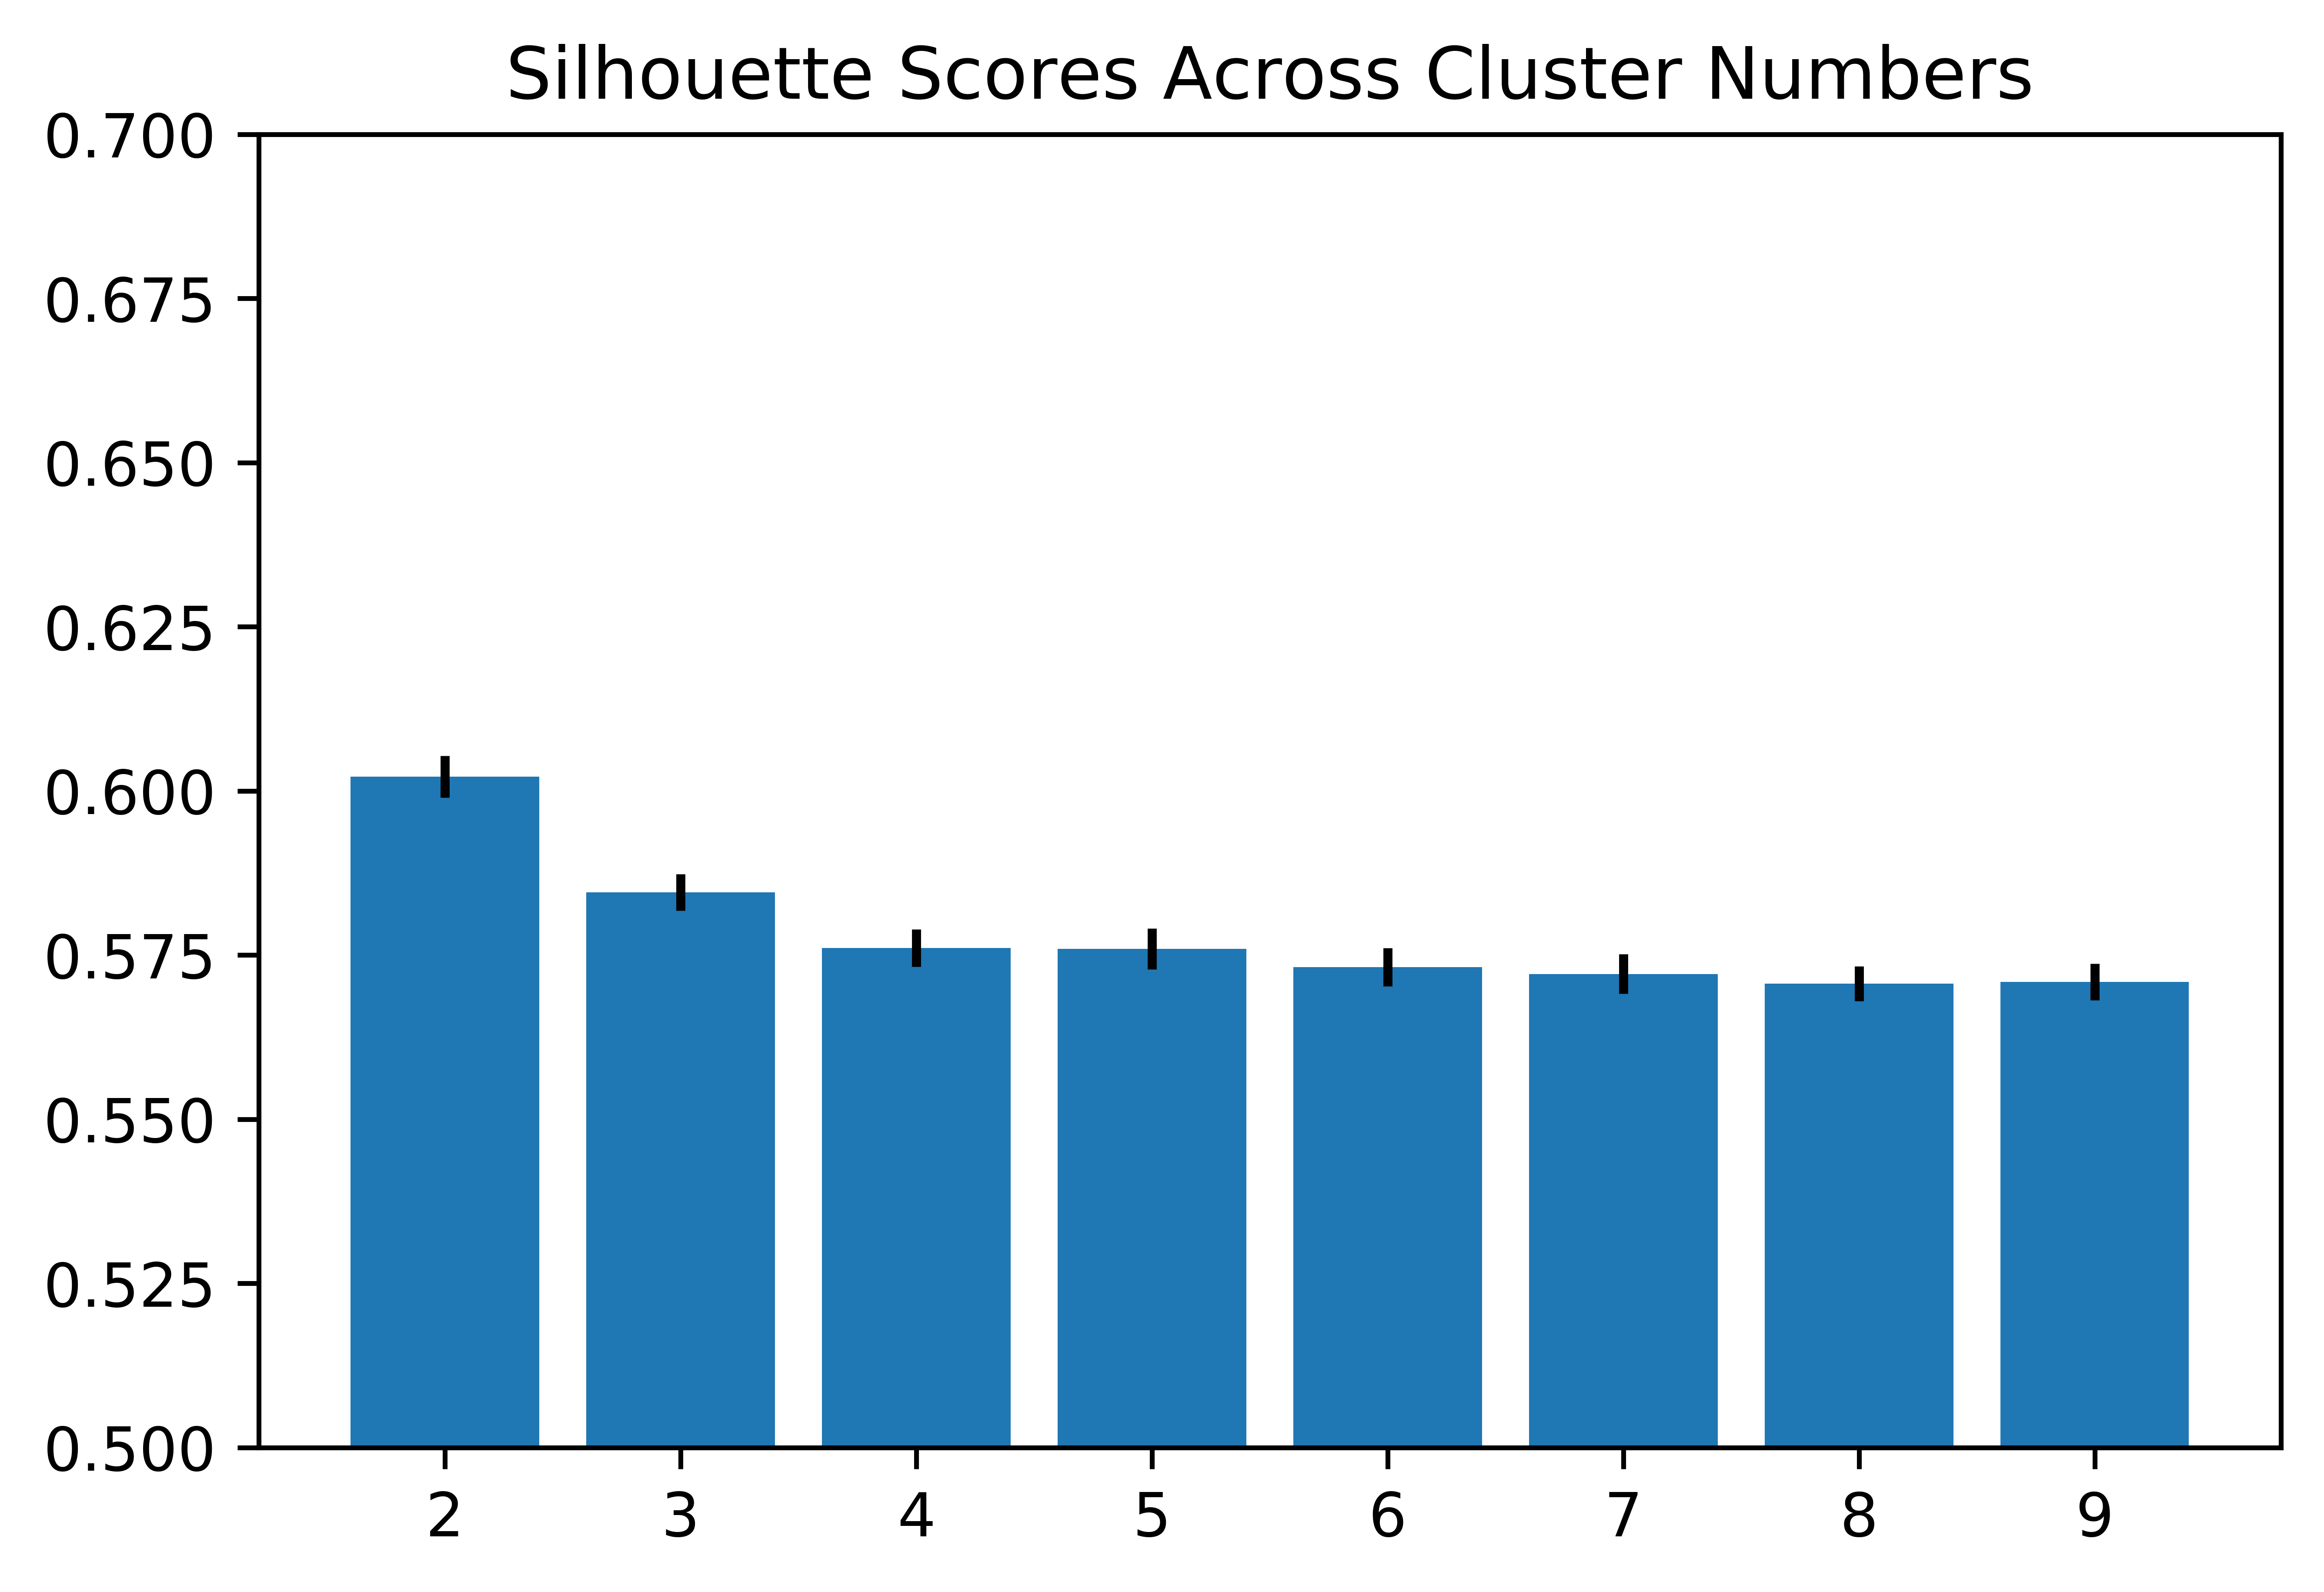

In [179]:
err=np.std(scores_all,axis=0)/np.sqrt(np.asarray(scores_all).shape[0])
plt.figure(dpi=1000)
plt.bar(range(len(options)),np.asarray(scores_all).mean(axis=0),yerr=err)
plt.xticks(range(len(options)),options)
plt.ylim((0.5,0.7))
plt.title("Silhouette Scores Across Cluster Numbers")
plt.savefig("cluster_scores.png")

the default signal_group_mode will change from 'split-all' to 'group-by-same-units' in next release


[146618 211272 275858 342119 406704 471286 534178 600459 665090 729635
 794283 857114 921774 986277]


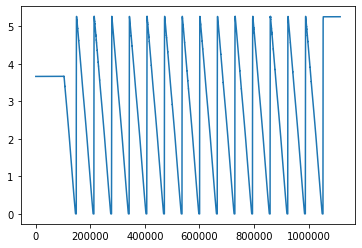

In [18]:
x=load_data('lab6/19o09013-fly2-csf-cont-ccw-5s-2so.abf')
times_data,mag_data=x[0]
times_mro,mag_mro=x[1]
idxs=np.where(mag_mro==0)[0]
change_points=idxs[np.where(np.diff(idxs)>5000)]
print(change_points)
plt.plot(mag_mro)

the default signal_group_mode will change from 'split-all' to 'group-by-same-units' in next release


[146618 211272 275858 342119 406704 471286 534178 600459 665090 729635
 794283 857114 921774 986277]


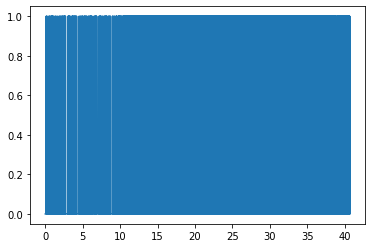

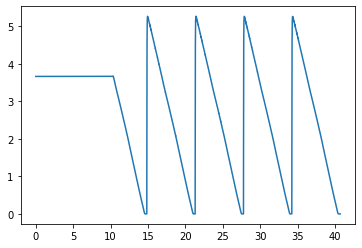

In [19]:
from scipy.stats import pearsonr
#x=load_data('lab7/data/19o09006.abf')
x=load_data('lab6/19o09013-fly2-csf-cont-ccw-5s-2so.abf')
#x=load_data('lab7/data/19o09006.abf')
#x=load_data('lab6/19o09013-fly2-csf-cont-ccw-5s-2so.abf')
#x=load_data('lab6/19o09014-fly2-ebl-cont-ccw-5s-2so.abf')
times_data,mag_data=x[0]
times_mro,mag_mro=x[1]
idxs=np.where(mag_mro==0)[0]
change_points=idxs[np.where(np.diff(idxs)>5000)]
i=0
print(change_points)

vals=[]
#fig,axarr=plt.subplots(2,sharex=True,dpi=1000)
end=change_points[-1]

data=mag_data[:end]
times=times_data[:end]

times_mro_s=times_mro[:end]
mag_mro_s=mag_mro[:end]



peak_idxs,peak_heights=peak_detection(data)
bin_spikes=np.zeros((data.shape[0],))
bin_spikes[peak_idxs]=1
        
cut=change_points[4]
plt.plot(times[:cut],bin_spikes[:cut])
plt.figure()
plt.plot(times_mro_s[:cut],mag_mro_s[:cut])



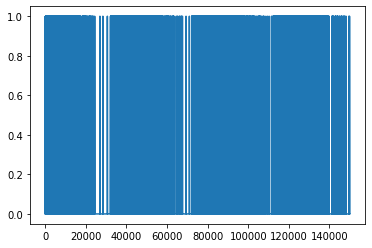

In [190]:
plt.plot(direc)

the default signal_group_mode will change from 'split-all' to 'group-by-same-units' in next release


[ 18635  38446  58406  78469  98460 118230 138437 158427 178458 198465
 218322 238339 258468 278551 298480 318525 338540 358343 378555 398607
 418412 438573 458295 478352 498398 518653]


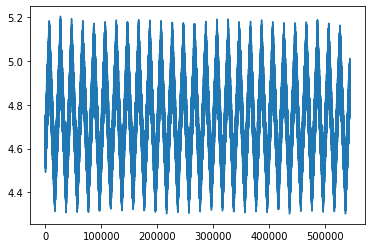

In [45]:
x=load_data('lab7/data/19o09006.abf')
#x=load_data('lab7/data/19o09006.abf')
#x=load_data('lab6/19o09013-fly2-csf-cont-ccw-5s-2so.abf')
#x=load_data('lab6/19o09014-fly2-ebl-cont-ccw-5s-2so.abf')
times_data,mag_data=x[0]
times_mro,mag_mro=x[1]
idxs=np.where(mag_mro<4.4)[0]
change_points=idxs[np.where(np.diff(idxs)>5000)]
plt.plot(mag_mro)
print(change_points)

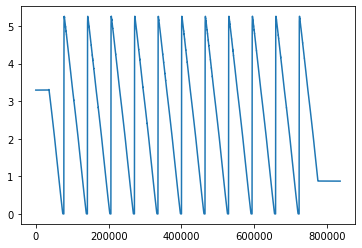

In [50]:
plt.plot(mag_mro)

the default signal_group_mode will change from 'split-all' to 'group-by-same-units' in next release


[ 76976 141616 206144 270772 335304 399939 464490 529101 593677 658281]
0
(0.24883071068717663, 0.004461645605047916)
1
(-0.24356959206866255, 0.005410648611824198)
2
(-0.11045804667874974, 0.21270262994970507)
3
(-0.07192998535682762, 0.41790239012689734)
4
(-0.038630339552184284, 0.6638179255542168)
5
(-0.13184197363230063, 0.13638962103142063)
6
(-0.09042080402480004, 0.3081668144994368)
7
(-0.11095432332566028, 0.21064204731008143)
8
(-0.019240019082745457, 0.8286622076913226)


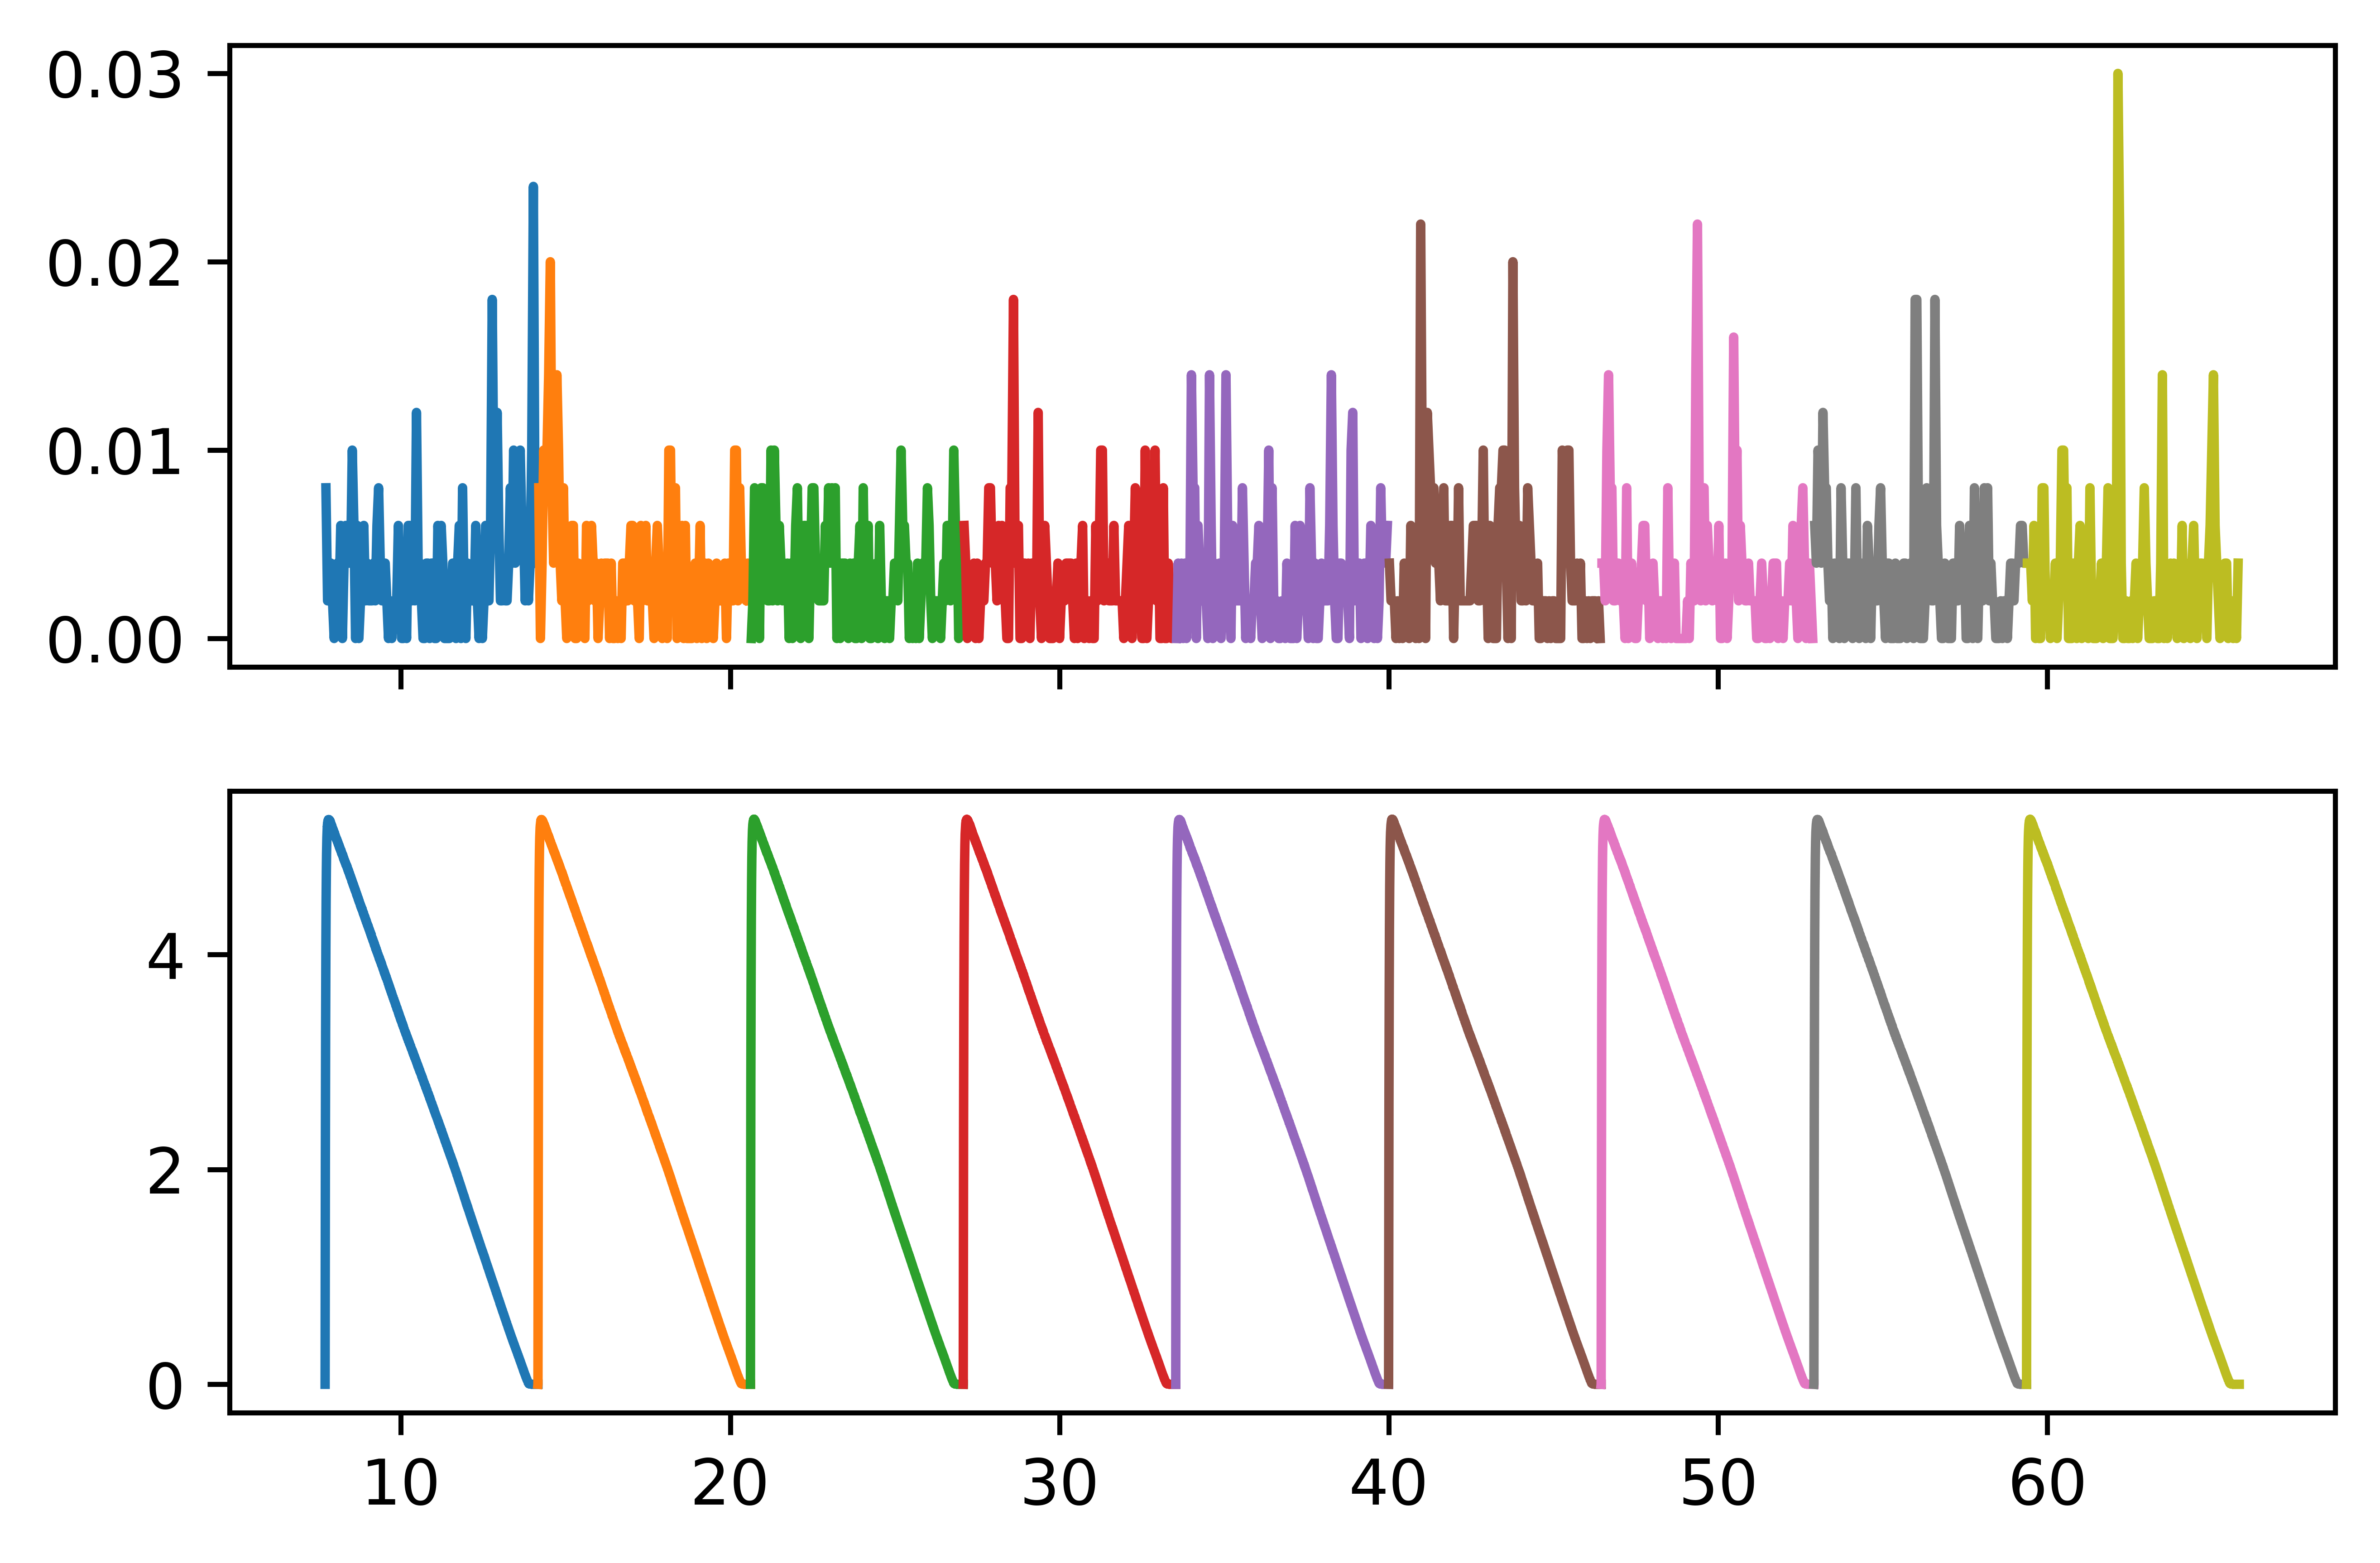

In [49]:
from scipy.stats import pearsonr
from sklearn.cluster import KMeans
#x=load_data('lab6/19o09012-fly2-csf-osc-ccw-5s-2so.abf')
x=load_data('lab6/19o09014-fly2-cg-cont-ccw-5s-2so.abf')
#x=load_data('lab7/data/19o09006.abf')
#x=load_data('lab6/19o09013-fly2-csf-cont-ccw-5s-2so.abf')
#x=load_data('lab6/19o09014-fly2-ebl-cont-ccw-5s-2so.abf')
times_data,mag_data=x[0]
times_mro,mag_mro=x[1]
idxs=np.where(mag_mro==0)[0]
change_points=idxs[np.where(np.diff(idxs)>5000)]
i=0
print(change_points)

vals=[]
fig,axarr=plt.subplots(2,sharex=True,dpi=1000)
#fig,axarr=plt.subplots(2,dpi=1000)



while i<len(change_points)-1:
    print(i)
    a=change_points[i]
    b=change_points[i+1]
    i+=1
    peak_idxs,peak_heights=peak_detection(mag_data[a:b])
    X=peak_heights.reshape([-1,1])
    km = KMeans(n_clusters=2).fit(X)
    
    #ifr=1/np.diff(peak_idxs)
    #fig,axarr=plt.subplots(2,sharex=True)
    #axarr[0].plot(times_data[a:b],mag_data[a:b])
    #axarr[0].plot(times_data[a:b][peak_idxs],peak_heights,'go')
    
    intervals=list(range(0,b-a,500))
    j=0
    interval_times=[]
    interval_vals=[]
    
    while j<len(intervals)-1:
        start=intervals[j]
        finish=intervals[j+1]
        j+=1
        interval_times.append((times_data[a:b][start]+times_data[a:b][finish])/2.0)
        interval_vals.append(len([idx for idx in peak_idxs if idx>= start and idx<finish])/500)
    interval_times=np.asarray(interval_times)
    interval_vals=np.asarray(interval_vals)
    
    #fig,axarr=plt.subplots(2,sharex=True)
    
    #top_time=times_mro[a:b][np.where(mag_mro[a:b]==np.max(mag_mro[a:b]))[0][0]]
    #top=np.argmin(np.absolute(interval_times-top_time))
    
    #print(np.mean(interval_vals[top:])-np.mean(interval_vals[:top]))
    print(pearsonr(interval_times,interval_vals))
    vals.append(interval_vals)
    
    #axarr[0].set_title(i)
    ifr=1/np.diff(peak_idxs)
    bin_spikes=np.zeros((mag_data[a:b].shape[0],))
    bin_spikes[peak_idxs]=1.0
    
    slopes=np.diff(mag_mro[a:b][:,0])
    stimulus=np.zeros((mag_mro[a:b].shape[0]))
    
    #plt.plot(times_mro[a:b],stimulus)
    #plt.plot(times_data[a:b],bin_spikes)
    #axarr[0].plot(times_data[a:b][peak_idxs],mag_data[a:b][peak_idxs])
    #fig,axarr=plt.subplots(2,sharex=True)
    axarr[0].plot(interval_times,interval_vals)
    axarr[1].plot(times_mro[a:b],mag_mro[a:b])
#vals=np.asarray(vals)
#print(vals.shape)
#axarr[0].plot(np.mean(vals,axis=0))

In [26]:
times_data[1]*1000*1000

100.0

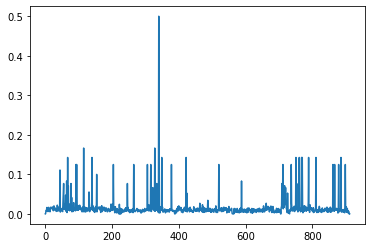

In [429]:
peak_idxs,peak_heights=peak_detection(mag_data[:200000])
plt.plot((1/np.diff(peak_idxs)))

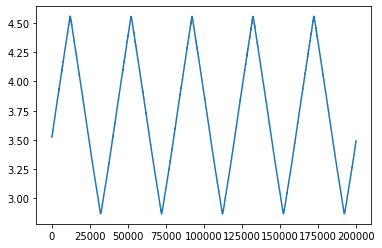

In [454]:
plt.plot(mag_mro[:200000])

In [446]:
mag_mro.shape

(1554944, 1)

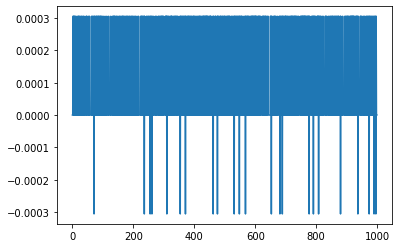

In [451]:
plt.plot(np.diff(mag_mro[:,0])[399000:400000])

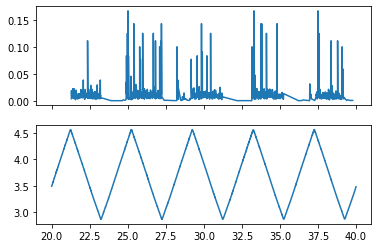

In [439]:
peak_idxs,peak_heights=peak_detection(mag_data[200000:400000])
ifr=(1/np.diff(peak_idxs))
fig,axarr=plt.subplots(2,sharex=True)
axarr[0].plot(times_data[200000:400000][peak_idxs][1:],ifr)
axarr[1].plot(times_mro[200000:400000],mag_mro[200000:400000])

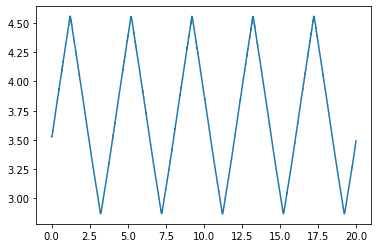

In [433]:
plt.plot(times_mro[:200000],mag_mro[:200000])

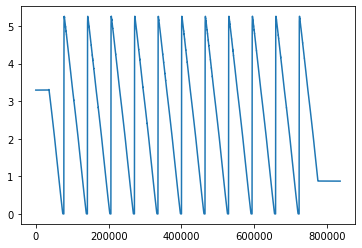

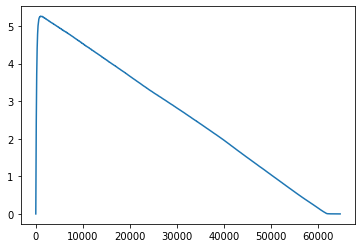

In [379]:
plt.plot(mag_mro)
plt.figure()
plt.plot(mag_mro[change_points[0]:change_points[1]])

the default signal_group_mode will change from 'split-all' to 'group-by-same-units' in next release


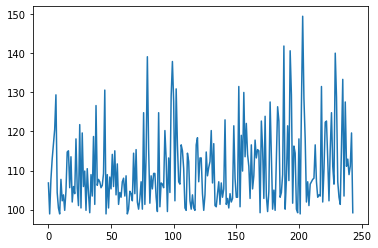

In [408]:
x=load_data('lab6/19o09014-fly2-cg-cont-ccw-5s-2so.abf')
times_data,mag_data=x[0]
times_mro,mag_mro=x[1]
amp=mag_data[change_points[0]:change_points[1]]
time=times_data[change_points[0]:change_points[1]]
idxs,peaks=peak_detection(amp)
#plt.plot(time,amp)
plt.plot(amp[np.asarray(idxs)])

the default signal_group_mode will change from 'split-all' to 'group-by-same-units' in next release


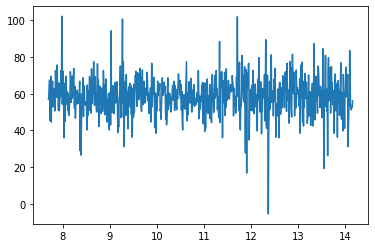

In [392]:
x=load_data('lab6/19o09013-fly2-csf-cont-cw-5s-2so.abf')
times_data,mag_data=x[0]
times_mro,mag_mro=x[1]
amp=mag_data[change_points[0]:change_points[1]]
time=times_data[change_points[0]:change_points[1]]
plt.plot(time[::90],amp[::90])

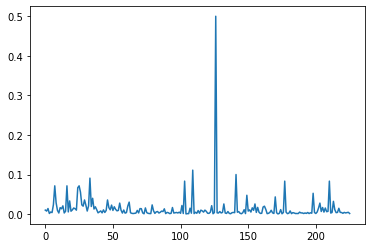

In [362]:
plt.plot(ifr_ccw[1])